In [1]:
import matplotlib.pyplot as plt
import numpy as np
import json

In [2]:
def extract_keypoints_from_a_json(origin_vid_dir):
    with open(origin_vid_dir, "r") as f:
        origin_keypoints = json.load(f)

    origin_keypoints_anno = origin_keypoints['annotations']
    origin_tmp_list = []
    for frame_data in origin_keypoints_anno:
        if frame_data:
            keypoints_list = [frame_data[key] for key in frame_data if frame_data[key]]
            if keypoints_list:
                origin_tmp_list.extend(keypoints_list)

    # # Nonetype error 발생하는 듯
    # if not origin_tmp_list:
    #     return None

    # reshape x
    origin_anchor_keypoints = np.array(origin_tmp_list)[:,:,[0,1]]
    return origin_anchor_keypoints

In [3]:
def compute_heatmap(keypoints, h=1080, w=1920, std=5, rate=0.25):
    points = keypoints.reshape(-1,2)

    x_points = points[:,[0]]
    y_points = points[:,[1]]

    H = np.tile(np.arange(int(h * rate))[:, None], int(w * rate))
    W = np.tile(np.arange(int(w * rate))[:, None], int(h * rate)).T

    heatmap_list = []
    for i in range(len(x_points)):
        x = x_points[i]
        y = y_points[i]
        x_gauss = 1/(np.sqrt(2*np.pi)*std) * np.exp(-0.5*((H-x)/std)**2) 
        y_gauss = 1/(np.sqrt(2*np.pi)*std) * np.exp(-0.5*((W-y)/std)**2)
        frame = (x_gauss * y_gauss)
        heatmap_list.append(frame)
    heatmaps = np.array(heatmap_list).reshape(-1, 17, int(h * rate), int(w * rate))

    return heatmaps

In [5]:
data_dir = "dataset/a001_kp/S001C001P001R001A001_rgb_kp.json"
rate = 0.25
origin_anchor_keypoints = extract_keypoints_from_a_json(data_dir) * rate
heatmaps = compute_heatmap(origin_anchor_keypoints, rate = rate)

In [6]:
print(origin_anchor_keypoints.shape)

(35, 17, 2)


In [7]:
print(heatmaps.shape)

(35, 17, 270, 480)


In [8]:
flow_x = []
flow_y = []
for i in range(1, len(origin_anchor_keypoints)):
    flow_x.append((origin_anchor_keypoints[i] - origin_anchor_keypoints[i-1])[:,[0]])
    flow_y.append((origin_anchor_keypoints[i] - origin_anchor_keypoints[i-1])[:,[1]])

In [9]:
print(np.array(flow_x).shape)
print(np.array(flow_y).shape)

(34, 17, 1)
(34, 17, 1)


In [10]:
h = int(1080*rate)
w = int(1920*rate)
hw_zeros = np.zeros(shape=(h,w))

In [11]:
opt_flow_x = []
opt_flow_y = []
for i in range(1,len(heatmaps)):
    heatmap = heatmaps[i]
    for j in range(len(heatmap)):
        tmp_x = hw_zeros + flow_x[i-1][j]
        tmp_y = hw_zeros + flow_y[i-1][j]
        opt_flow_x.append(tmp_x * heatmap[j])
        opt_flow_y.append(tmp_y * heatmap[j])


In [12]:
reshape_opt_flow_y = (np.array(opt_flow_y)).reshape(-1,17,1,h,w)

In [13]:
reshape_opt_flow_x = (np.array(opt_flow_x)).reshape(-1,17,1,h,w)

In [14]:
print(reshape_opt_flow_x.shape)
print(reshape_opt_flow_y.shape)
print(np.concatenate((reshape_opt_flow_x,reshape_opt_flow_y),axis=2).shape)

(34, 17, 1, 270, 480)
(34, 17, 1, 270, 480)
(34, 17, 2, 270, 480)


In [ ]:
for j in range(len(reshape_opt_flow_x)):
    tmp_flow_x = reshape_opt_flow_x[j].reshape(17,h,w)
    for i in range(len(tmp_flow_x)):
        if i == 0:
            tmp_flow_plt_x = tmp_flow_x[0]
        else:
            tmp_flow_plt_x += tmp_flow_x[i]

    plt.imshow(tmp_flow_plt_x)
    plt.savefig(f"opt_flow/x_270_480/x_frame{j}.jpg")

In [ ]:
for j in range(len(reshape_opt_flow_y)):
    tmp_flow_y = reshape_opt_flow_y[j].reshape(17,h,w)
    for i in range(len(tmp_flow_y)):
        if i == 0:
            tmp_flow_plt_y = tmp_flow_y[0]
        else:
            tmp_flow_plt_y += tmp_flow_y[i]

    plt.imshow(tmp_flow_plt_y)
    plt.savefig(f"opt_flow/y_270_480/y_frame{j}.jpg")

In [ ]:
for i in range(len(opt_flow_x)):
    plt.imshow(opt_flow_x[i])
    plt.savefig(f"opt_flow/x/x_frame{i}.jpg")

In [58]:
print(len(heatmaps))
print(heatmaps[0].shape)
heatmap = heatmaps[0]
print(heatmap[0].shape)
print(len(flow_x))
print(flow_x[0].shape)
print(flow_x[0][0].shape)
tmp_x = hw_zeros + flow_x[0][0]
print(tmp_x.shape)

35
(17, 1080, 1920)
(1080, 1920)
34
(17, 1)
(1,)
(1080, 1920)


In [20]:
tmp_x = hw_zeros+flow_x[0]
tmp_y = hw_zeros+flow_y[0]

In [24]:
print(tmp_x.shape)
print(heatmaps[1][0].shape)
print((tmp_x * heatmaps[1][0]).shape)

(1080, 1920)
(1080, 1920)
(1080, 1920)


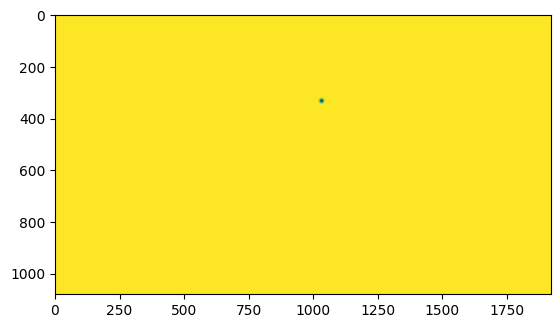

In [25]:
op_flow_x = tmp_x * heatmaps[1][0]
plt.imshow(op_flow_x)

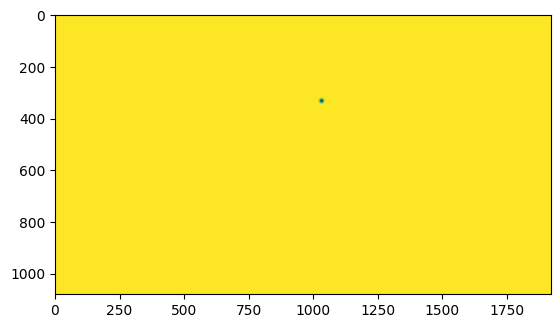

In [26]:
op_flow_y = tmp_y * heatmaps[1][0]
plt.imshow(op_flow_y)